In [33]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer
import lightgbm as lgb

In [34]:
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fredd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fredd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [35]:
df = pd.read_csv('data.tsv', sep='\t')

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 2 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   sentiment_label  160000 non-null  int64 
 1   tweet_text       160000 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [37]:
df.head()

,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


In [38]:
df[df.isna().any(axis=1)]

,sentiment_label,tweet_text


In [39]:
df['sentiment_label'].value_counts()

4    80000
0    80000
Name: sentiment_label, dtype: int64

In [40]:
pattern = r'https?://[^\s]+|www\.[^\s]+|\.[a-z]{2,}'
df['tweet_text'] = df['tweet_text'].apply(lambda x: re.sub(pattern, ' ', x).lower())

In [41]:
pattern = r'[^a-zA-Z0-9\s]'
df['tweet_text'] = df['tweet_text'].apply(lambda x: re.sub(pattern, '', x))

In [42]:
pattern = r'(.)\1{2,}'
df['tweet_text'] = df['tweet_text'].apply(lambda x: re.sub(pattern, r'\1\1', x))

In [43]:
lemmatizer = WordNetLemmatizer()

In [44]:
def lemm(text):
    words = word_tokenize(text)
    lemm_words = [lemmatizer.lemmatize(word) for word in words]
    return lemm_words

In [45]:
df['tweet_text'] = df['tweet_text'].apply(lemm)

In [46]:
df['tweet_text'] = df['tweet_text'].apply(lambda x: ' '.join(x))

In [47]:
df['sentiment_label'] = df['sentiment_label'].apply(lambda x: 1 if x == 4 else 0)

In [48]:
X = df['tweet_text']
y = df['sentiment_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [49]:
tfidf_vectorizer = TfidfVectorizer()

In [50]:
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

In [51]:
regressor = LogisticRegression()

In [52]:
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
y_prob = regressor.predict_proba(X_test)[:, 1]

In [53]:
print("\n\nAccuracy:", accuracy_score(y_test, y_pred), "\n\nROC:", roc_auc_score(y_test, y_pred), "\n\nClassification report:\n", classification_report(y_test, y_pred))



Accuracy: 0.78628125 

ROC: 0.7862818677544041 

Classification report:
               precision    recall  f1-score   support

           0       0.79      0.78      0.79     16002
           1       0.78      0.79      0.79     15998

    accuracy                           0.79     32000
   macro avg       0.79      0.79      0.79     32000
weighted avg       0.79      0.79      0.79     32000



In [54]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [55]:
def train_and_predict(params, train_data, test_data):
    
    model_lgb = lgb.train(params, train_data, valid_sets=[train_data, test_data], num_boost_round=500, callbacks=[lgb.early_stopping(stopping_rounds=50)])

    y_pred = model_lgb.predict(X_test, num_iteration=model_lgb.best_iteration)

    y_pred_binary = (y_pred >= 0.5).astype(int)

    accuracy = accuracy_score(y_test, y_pred_binary)
    roc_auc = roc_auc_score(y_test, y_pred)

    return (accuracy, roc_auc, y_test, y_pred)

In [56]:
stats = []

for leaves in range(40, 151, 20):
    for learning in range(10, 301, 50):
        params = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'learning_rate': learning/1000,
            'num_leaves': leaves,
        }

        acc, roc, y_test, y_pred = train_and_predict(params, train_data, test_data)

        stats.append([leaves, learning, acc, roc])


[LightGBM] [Info] Number of positive: 64002, number of negative: 63998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.627192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 208423
[LightGBM] [Info] Number of data points in the train set: 128000, number of used features: 4321
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500016 -> initscore=0.000063
[LightGBM] [Info] Start training from score 0.000063
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	training's binary_logloss: 0.51178	valid_1's binary_logloss: 0.520252
[LightGBM] [Info] Number of positive: 64002, number of negative: 63998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.610566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tot

In [57]:
s1 = pd.DataFrame(stats.copy())
s1.columns = ['num_leaves', 'learning_rate', 'accuracy', 'roc']
s1['learning_rate'] = s1['learning_rate'] / 1000

In [58]:
s1.sort_values('accuracy', ascending=False).head()

,num_leaves,learning_rate,accuracy,roc
31,140,0.06,0.789500,0.868554
25,120,0.06,0.788438,0.868658
13,80,0.06,0.787687,0.867729
19,100,0.06,0.787594,0.867996
15,80,0.16,0.787594,0.866248


In [59]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.06,
    'num_leaves': 120,
}
accuracy, roc_auc, y_test, y_pred = train_and_predict(params, train_data, test_data)

[LightGBM] [Info] Number of positive: 64002, number of negative: 63998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.629616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 208423
[LightGBM] [Info] Number of data points in the train set: 128000, number of used features: 4321
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500016 -> initscore=0.000063
[LightGBM] [Info] Start training from score 0.000063
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.350149	valid_1's binary_logloss: 0.454018


In [60]:
y_pred_binary = (y_pred >= 0.5).astype(int)

In [61]:
print("\n\nAccuracy:", accuracy_score(y_test, y_pred_binary), "\n\nROC:", roc_auc_score(y_test, y_pred), "\n\nClassification report:\n", classification_report(y_test, y_pred_binary))



Accuracy: 0.7884375 

ROC: 0.8686584510727884 

Classification report:
               precision    recall  f1-score   support

           0       0.79      0.78      0.79     16002
           1       0.78      0.80      0.79     15998

    accuracy                           0.79     32000
   macro avg       0.79      0.79      0.79     32000
weighted avg       0.79      0.79      0.79     32000



In [62]:
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred)
roc_auc = auc(fpr1, tpr1)

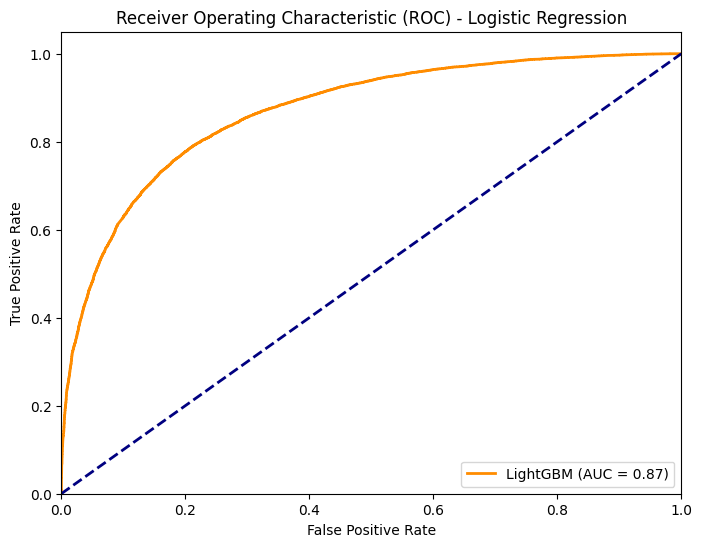

In [63]:
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label=f'LightGBM (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Logistic Regression')
plt.legend(loc="lower right")
plt.savefig('plots\\roc_lightgbm.png', dpi=300)
plt.show()

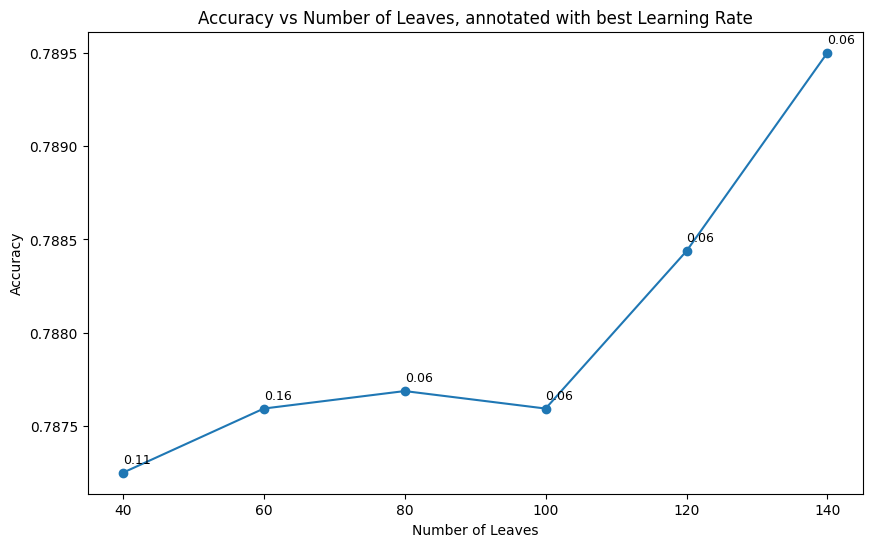

In [64]:
stats_leaves_sorted = s1.sort_values('accuracy', ascending=False).drop_duplicates(subset=['num_leaves'], keep='first').sort_values('num_leaves', ascending=True)

plt.figure(figsize=(10, 6))
plt.plot(stats_leaves_sorted['num_leaves'], stats_leaves_sorted['accuracy'], marker='o')
for index, row in stats_leaves_sorted.iterrows():
    plt.text(row['num_leaves'], row['accuracy'] + 0.00005, str(row['learning_rate']), fontsize=9, )
plt.title('Accuracy vs Number of Leaves, annotated with best Learning Rate')
plt.xlabel('Number of Leaves')
plt.ylabel('Accuracy')
plt.savefig('plots\\acc_vs_num_leaves.png', dpi=300)
plt.show()

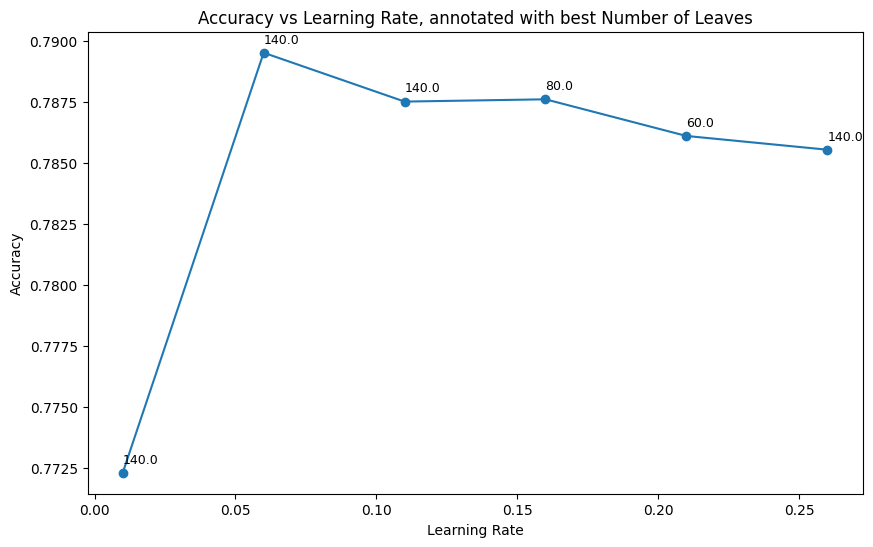

In [65]:
stats_learning_rate_sorted = s1.sort_values('accuracy', ascending=False).drop_duplicates(subset=['learning_rate'], keep='first').sort_values('learning_rate', ascending=True)

plt.figure(figsize=(10, 6))
plt.plot(stats_learning_rate_sorted['learning_rate'], stats_learning_rate_sorted['accuracy'], marker='o')
for index, row in stats_learning_rate_sorted.iterrows():
    plt.text(row['learning_rate'], row['accuracy'] + 0.0004, str(row['num_leaves']), fontsize=9, )
plt.title('Accuracy vs Learning Rate, annotated with best Number of Leaves')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.savefig('plots\\acc_vs_learning_rate.png', dpi=300)
plt.show()

In [66]:
max_length = 128
max_features = 30522

In [67]:
X = df['tweet_text']
y = df['sentiment_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

In [68]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

X_train_encoded = [tokenizer.encode(text, add_special_tokens=True) for text in X_train]
X_test_encoded = [tokenizer.encode(text, add_special_tokens=True) for text in X_test]

X_train_padded = pad_sequences(X_train_encoded, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_encoded, maxlen=max_length, padding='post')


In [69]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_padded, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32)


In [70]:
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=128, input_length=max_length, mask_zero=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

In [71]:

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [72]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 128, 128)          3906816   
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3956289 (15.09 MB)
Trainable params: 3956289 (15.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


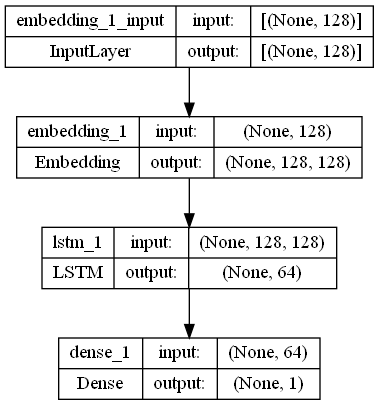

In [73]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='plots\\model_plot.png', show_shapes=True, show_layer_names=True)

In [74]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

In [75]:
history = model.fit(train_dataset, epochs=10, validation_data=(X_test_padded, y_test), callbacks=[early_stopping])

Epoch 1/10


4000/4000 [==============================] - 278s 68ms/step - loss: 0.4775 - accuracy: 0.7712 - val_loss: 0.4458 - val_accuracy: 0.7926
Epoch 2/10
4000/4000 [==============================] - 273s 68ms/step - loss: 0.3892 - accuracy: 0.8232 - val_loss: 0.4599 - val_accuracy: 0.7906
Epoch 3/10
4000/4000 [==============================] - 273s 68ms/step - loss: 0.3048 - accuracy: 0.8683 - val_loss: 0.5441 - val_accuracy: 0.7732
Epoch 4/10
4000/4000 [==============================] - 273s 68ms/step - loss: 0.2217 - accuracy: 0.9089 - val_loss: 0.6930 - val_accuracy: 0.7557
Epoch 4: early stopping


In [76]:
test_loss, test_acc = model.evaluate(X_test_padded, y_test, verbose=2)

1000/1000 - 12s - loss: 0.4458 - accuracy: 0.7926 - 12s/epoch - 12ms/step


In [77]:
predictions = model.predict(X_test_padded)

1000/1000 [==============================] - 13s 12ms/step


In [78]:
y_pred_binary = (predictions >= 0.5).astype(int)

In [79]:
print("\n\nAccuracy:", accuracy_score(y_test, y_pred_binary), "\n\nROC:", roc_auc_score(y_test, predictions), "\n\nClassification report:\n", classification_report(y_test, y_pred_binary))



Accuracy: 0.792625 

ROC: 0.8760054082188344 

Classification report:
               precision    recall  f1-score   support

           0       0.81      0.77      0.79     16002
           1       0.78      0.82      0.80     15998

    accuracy                           0.79     32000
   macro avg       0.79      0.79      0.79     32000
weighted avg       0.79      0.79      0.79     32000



In [80]:
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

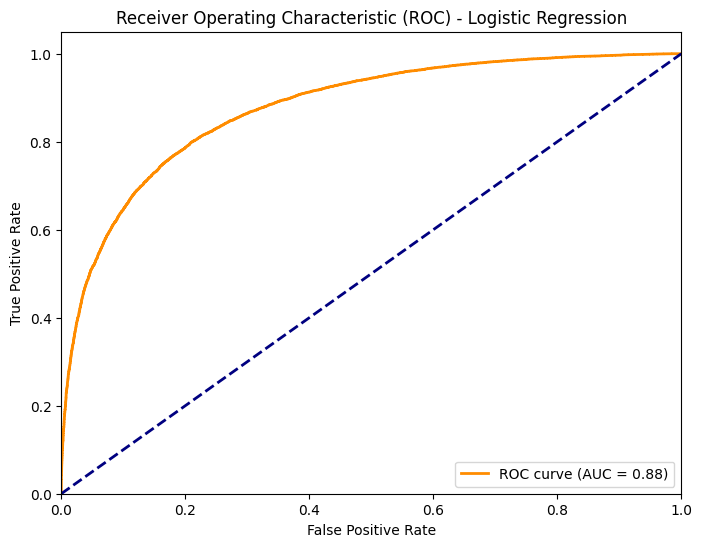

In [81]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Logistic Regression')
plt.legend(loc="lower right")
plt.savefig('plots\\roc_nn.png', dpi=300)
plt.show()

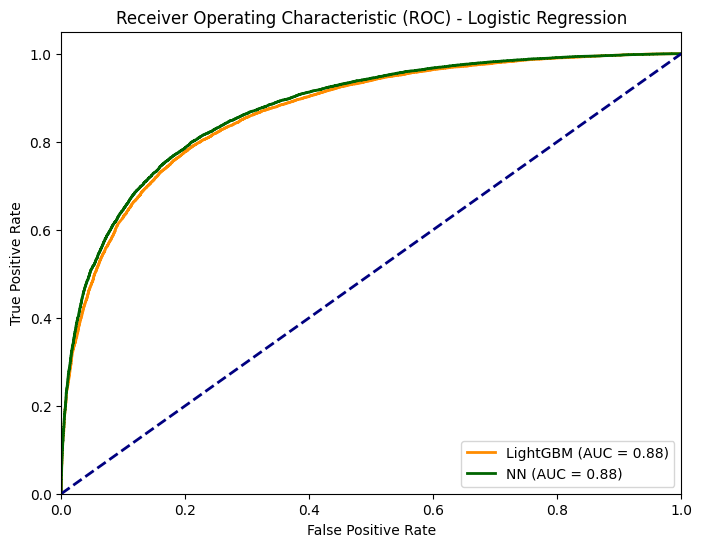

In [82]:
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label=f'LightGBM (AUC = {roc_auc:.2f})')
plt.plot(fpr, tpr, color='darkgreen', lw=2, label=f'NN (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Logistic Regression')
plt.legend(loc="lower right")
plt.savefig('plots\\roc_comparison.png', dpi=300)
plt.show()